## Imports

In [1]:
import os, torch, torchvision, time, copy, pickle, timm
from skimage import transform
from __future__ import print_function, division
import torch.nn as nn, torch.optim as optim, matplotlib.pyplot as plt, numpy as np, pandas as pd, seaborn as sn
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms, utils
from PIL import Image
from sklearn.metrics import confusion_matrix

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
MM_training = 1


with open('/kaggle/input/upmc-food-101-text-part/objs.pkl', 'rb') as f: 
    classes = pickle.load(f)
Num_class = len(classes)
print('Classes:', classes, '\nNumber of Classes:', Num_class)


def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.yticks([])  
    plt.xticks([])  
    plt.imshow(inp)
    plt.savefig('Augmented_food.pdf', bbox_inches = 'tight') 
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

Classes: ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 

## Links

In [2]:
Text_Model_link = '/kaggle/input/upmc-food-101-text-part/RNN_text_model.pt'
Texts_csv = {
    'train': '/kaggle/input/upmc-food-101-text-part/train.csv',
    'valid': '/kaggle/input/upmc-food-101-text-part/valid.csv',
    'test' : '/kaggle/input/upmc-food-101-text-part/test.csv'
}

Image_folders = {
    'root' : '/kaggle/input/upmcfood101/images',
    'train': '/kaggle/input/upmcfood101/images/train',
    'valid': '/kaggle/input/upmcfood101/images/train',
    'test' : '/kaggle/input/upmcfood101/images/test'
}

In [3]:
class MultimodalDataset(Dataset):
    # Modified from: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
    def __init__(self, csv_file, root_dir, transform = None):
        self.csv_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.csv_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        labels = int(self.csv_frame.iloc[idx, 2])
        
        img_link = self.root_dir +'/' + classes[labels] +'/' + self.csv_frame.iloc[idx, 0]
        image = Image.open(img_link)
        
        other_inputs = torch.from_numpy(np.asarray(self.csv_frame.iloc[idx, 3:104].tolist()))
        sample = {'image': image, 'information': other_inputs,'labels': labels}

        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

## MM Transforms

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((244,244)),
        transforms.RandomRotation(15,),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
}

class MM_transform(object):
    def __init__(self, phase):
        assert isinstance(phase,(str))
        self.phase = phase
        
    def __call__(self, sample):
        image, information, labels = sample['image'],sample['information'], sample['labels']
        #image, labels = sample['image'], sample['labels']
        trnsfrm = data_transforms[self.phase]
        image = trnsfrm(image)
        
        return {'image': image, 'information': information, 'labels': labels}
        #return {'image': image, 'labels': labels}

## Dataloader with Multimodal Transform

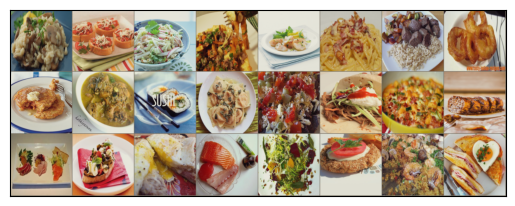

In [5]:
def dataset_phase(phase):
    return MultimodalDataset(csv_file = Texts_csv[phase], root_dir = Image_folders[phase],
                        transform = MM_transform(phase))

def dataloader_phase(phase):
    return DataLoader(dataset[phase], batch_size = 24, shuffle=True, num_workers=0)
    
dataset = {x: dataset_phase(x) for x in ['train', 'valid', 'test']}
dataloaders = {x: dataloader_phase(x) for x in ['train', 'valid', 'test']}
dataset_sizes = {x: len(dataset[x]) for x in ['train', 'valid', 'test']}
               
sample_batch = next(iter(dataloaders['valid']))
out = torchvision.utils.make_grid(sample_batch['image'])
imshow(out)

In [6]:
class NullNet(nn.Module): 
    def __init__(self):
        super(NullNet, self).__init__()
    def forward(self, x):
        return x
    
#model_ft = models.resnet50(pretrained=False)
#num_ftrs = model_ft.fc.in_features
#model_ft.fc = nn.Linear(num_ftrs, Num_class)


model_ft = timm.create_model('vit_large_patch16_224', pretrained=False, num_classes=Num_class)
num_ftrs = model_ft.head.in_features
PATH2 = "/kaggle/input/upmc-food-101-unimodal-image-training-vit/fine_tuned_model.pt"
model_ft.load_state_dict(torch.load(PATH2, map_location=device))
model_ft.head = NullNet()

model_fc = nn.Linear(num_ftrs, Num_class)
if MM_training:
    model_fc = nn.Linear(num_ftrs + Num_class, Num_class).to(torch.float64)

/tmp/ipykernel_19/259584889.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_ft.load_state_dict(torch.load(PATH2, map_location=device))


In [7]:
def train_model_MM(model, model_fc, criterion, optimizer, scheduler, num_epochs=25, MM_training=1):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    test_token=0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid', 'test']:
            '''
            Test when a better validation result is found
            '''
            if test_token ==0 and phase == 'test':
                continue
            test_token =0
            
            
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for sample_batch in dataloaders[phase]:
                inputs = sample_batch['image'].to(device)
                labels = sample_batch['labels'].to(device)
                params = sample_batch['information'].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    features = model(inputs)
                    if MM_training:
                        features = torch.cat((features, params), 1)
                    outputs = model_fc(features)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model_fc.state_dict())
                test_token =1

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model_fc.load_state_dict(best_model_wts)
    return model_fc

In [8]:
optimizer_fc = optim.SGD(model_fc.parameters(), lr=0.0005, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_fc, step_size=7, gamma=0.1)
model_ft = model_ft.to(device)
model_fc = model_fc.to(device)
criterion = nn.CrossEntropyLoss()

model_fc = train_model_MM(model_ft, model_fc, criterion, optimizer_fc, exp_lr_scheduler, num_epochs=5, MM_training=MM_training)

Epoch 0/4
----------
train Loss: 0.3136 Acc: 0.9299
valid Loss: 0.1295 Acc: 0.9719
test Loss: 0.3462 Acc: 0.9217

Epoch 1/4
----------
train Loss: 0.1194 Acc: 0.9702
valid Loss: 0.0895 Acc: 0.9788
test Loss: 0.3276 Acc: 0.9256

Epoch 2/4
----------
train Loss: 0.0931 Acc: 0.9769
valid Loss: 0.0775 Acc: 0.9816
test Loss: 0.3416 Acc: 0.9251

Epoch 3/4
----------
train Loss: 0.0778 Acc: 0.9811
valid Loss: 0.0658 Acc: 0.9843
test Loss: 0.3460 Acc: 0.9245

Epoch 4/4
----------
train Loss: 0.0676 Acc: 0.9834
valid Loss: 0.0547 Acc: 0.9873
test Loss: 0.3383 Acc: 0.9264

Training complete in 446m 44s
Best val Acc: 0.987347
